# Mode fitting

Here we will make a simple hierarchical model that encodes some knowledge of quasi-equally spaced modes of oscillation into the prior.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

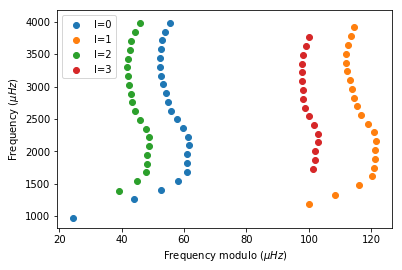

In [5]:
dnu_sol = 136  # book value of large freq separation for the sun

df = pd.read_table('broomhall2009.txt', delim_whitespace=True, names=('n', 'l', 'nu', 'nu_unc'))  #import data

lmodes = []
dnu_avg = []
f_mod = []

for i in range(4):
    lmodes.append(df[df.l == i])
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

The lower departure from a straight line is due to the BCZ, so the lower frequencies are not useful in analysing the response from the HeII ionization zone. Frequencies below 1700 $\mu$Hz are omitted.

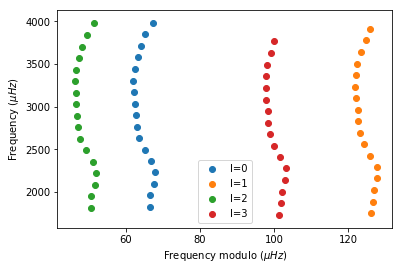

In [6]:
for i in range(4):
    lmodes[i] = lmodes[i].loc[lmodes[i].nu > 1700]
    lmodes[i] = lmodes[i].set_index(np.arange(0,len(lmodes[i]),1))

dnu_avg = []
f_mod = []
for i in range(4):
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

To find a ballpark figure before defining priors, I will apply the model from Vrard:

$$\nu_{UP}(n,0)=\bigg(n+\epsilon+\frac{\alpha}{2}(n-n_{max})^2+\frac{\mathcal{A}\mathcal{G}}{2\pi}sin\bigg(\frac{2\pi(n-n_{max})}{\mathcal{G}}+\phi\bigg)\bigg)\langle\Delta\nu\rangle$$

In [7]:
def model(n, dnu, numax, epsilon, alpha, A, G, phi):
    nmax = numax/dnu + epsilon
    freqs = (n + epsilon + (alpha/2)*(n-nmax)**2 + (A*G/2*np.pi)*np.sin(2*np.pi*(n-nmax)/G + phi))*dnu #Vrard universal pattern
    return freqs

In [8]:
n = lmodes[0].n
dnu = dnu_avg[0]
numax = 2800
epsilon = 1.437
alpha = 0.004 #from vrard paper
A = 0.06*dnu_avg[0]**(-0.88)
print(A)
G = 2
phi = np.pi/4
f = model(n, dnu, numax, epsilon, alpha, A, G, phi)

0.0008003460587489702


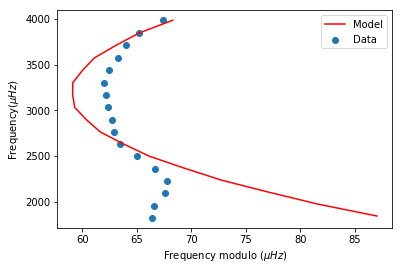

In [9]:
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.plot(f % dnu_avg[0], f, label = 'Model', color = 'r')
plt.ylabel(r'Frequency($\mu Hz$)')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.legend()
#plt.xlim(0, 135.2)

In [23]:
code = '''
functions {
    real model(real n, real dnu, real numax, real epsilon, real alpha, real A, real G, real phi){
        real nmax = numax/dnu + epsilon;
        real freqs = (n + epsilon + (alpha/2)*(n-nmax)^2 + (A*G/2*pi())*sin(2*pi()*(n-nmax)/G + phi))*dnu;
        return freqs;
    }
}
data {
    int N; // Data points
    real n[N];
    real dnu;
    real fobs[N];
}
parameters {
    real numax;
    real epsilon;
    real alpha;
    real A;
    real G;
    real<lower=-pi(), upper=pi()> phi;
}
model {
    vector[N] mod;
    numax ~ normal(2800, 100);
    epsilon ~ normal(1.45, 0.6);
    alpha ~ normal(0.005, 0.003);
    A ~ normal(0.001, 0.001);
    G ~ normal(3, 2);
    phi ~ normal(0, pi()/4);
    for (i in 1:N) mod[i] = model(n[i], dnu, numax, epsilon, alpha, A, G, phi);
    mod ~ normal(fobs, 10);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c31d1698d76a05cf9a91bfca2737ee95 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp5sn9mr8_/stanfit4anon_model_c31d1698d76a05cf9a91bfca2737ee95_7448103330603002340.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [24]:
stan_data = {'N': len(lmodes[0]), 'n': lmodes[0].n,
             'fobs': lmodes[0].nu, 'dnu': dnu_avg[0]
            }
nchains = 4
#start = {'A': 0, 'G': 2, 'phi': -np.pi}
fitsm = sm.sampling(data=stan_data, iter=10000, chains=nchains) # init=[start for n in range(nchains)])

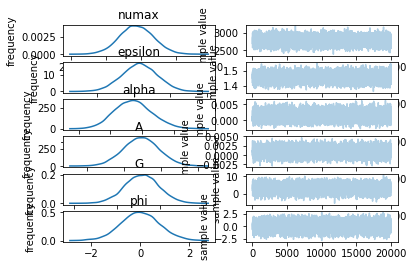

In [25]:
fitsm.plot()
plt.show()

In [26]:
print(fitsm)

Inference for Stan model: anon_model_c31d1698d76a05cf9a91bfca2737ee95.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
numax   2777.2    0.94  96.65 2587.7 2711.3 2776.3 2842.9 2968.1  10652    1.0
epsilon   1.46  2.5e-4   0.02   1.41   1.44   1.46   1.47   1.51   9715    1.0
alpha   1.4e-3  1.2e-5 1.2e-3-7.7e-4 6.2e-4 1.4e-3 2.2e-3 3.9e-3  10656    1.0
A       9.5e-4  6.9e-6 9.7e-4-9.3e-4 3.0e-4 9.5e-4 1.6e-3 2.9e-3  20019    1.0
G         2.92    0.02   1.99  -0.99   1.58   2.93   4.25   6.83   6816    1.0
phi     1.7e-3  7.5e-3   0.79  -1.56  -0.53-3.8e-3   0.53   1.58  11196    1.0
lp__     -3.57    0.02   1.78  -7.95  -4.51  -3.23  -2.28  -1.15   6930    1.0

Samples were drawn using NUTS at Fri Nov 30 13:51:30 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction fact

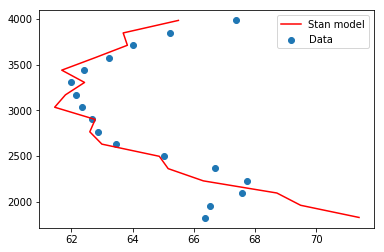

In [27]:
stanfit = model(lmodes[0].n, dnu_avg[0], fitsm['numax'].mean(), fitsm['epsilon'].mean(), fitsm['alpha'].mean(), fitsm['A'].mean(), fitsm['G'].mean(), fitsm['phi'].mean())

plt.subplots()
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.plot(stanfit % dnu_avg[0], stanfit, label = 'Stan model', color = 'r')
plt.legend()

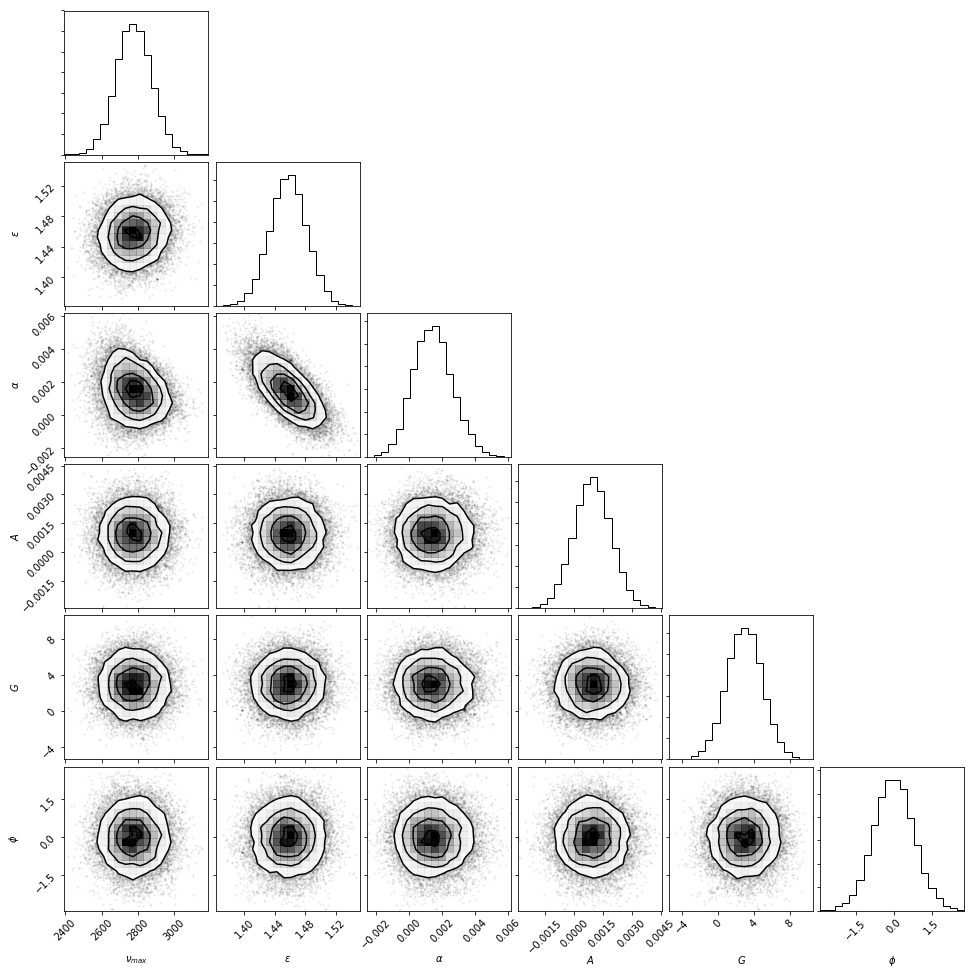

In [28]:
import corner
data = np.vstack([fitsm['numax'], fitsm['epsilon'], fitsm['alpha'], fitsm['A'], fitsm['G'], fitsm['phi'],]).T
corner.corner(data, labels=[r'$\nu_{max}$', r'$\epsilon$', r'$\alpha$', r'$A$', r'$G$', r'$\phi$'])
plt.show()

This analysis will use the methods detailed in Vrard 2015 and, as such, will use its definitions.

The definition for the local frequency spacing is:

$\Delta\nu(n) = \frac{\nu_{n+1,0}-\nu_{n-1,0}}{2}$.

At the edges of the measured radial modes, we cannot use this equation and replace it by the frequency difference between two consecutive radial modes.

In [89]:
lmodes[0]['dnu_n'] = (lmodes[0]['nu'].diff(2).shift(-1)/2)
lmodes[0]['dnu_n'][0] = lmodes[0]['nu'].diff(1)[1]
lmodes[0]['dnu_n'][16] = (lmodes[0]['nu'].diff(1)[16])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The stan model determined that the maximum frequency is $\nu_{max} = 2777.27 \mu Hz$. This is then used in the determination of the universal pattern to which the frequency separation will be compared:

$\Delta\nu_{UP}(n)=(1+\alpha(n-n_{max}))\langle\Delta\nu\rangle$

We compute the difference between the observed local large separation and the theoretical local large separation predicted by the universal pattern:

$\delta_{g,obs}=\Delta\nu(n)-\Delta\nu_{UP}(n)$

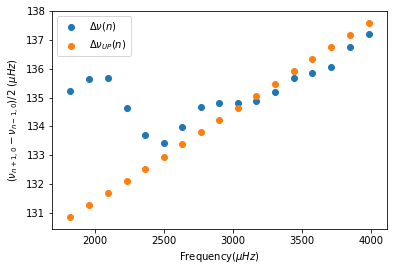

In [90]:
nmax = 22
numax = 3168.618
alpha = 0.015*dnu_avg[0]**(-0.32)
dnu_UP = (1+alpha*(lmodes[0].n-nmax))*dnu_avg[0]

plt.scatter(lmodes[0].nu, lmodes[0].dnu_n, label = r'$\Delta\nu(n)$')
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'$(\nu_{n+1,0}-\nu_{n-1,0})/2$ ($\mu Hz$)')
plt.scatter(lmodes[0].nu, dnu_UP, label = r'$\Delta\nu_{UP}(n)$')
plt.legend()

We now subtract the universal pattern from the data in order to remove the curvature term.

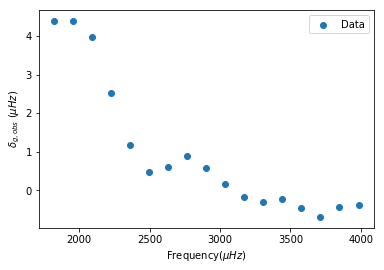

In [91]:
deltag = lmodes[0].dnu_n - dnu_UP

plt.scatter(lmodes[0].nu, deltag, label='Data')
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'$\delta_{g,obs}$ ($\mu Hz$)')
plt.legend()

The amplitude can be found by fitting an oscillatory component to the resultant frequency variations obtained after removal of the curvature term from the measurements:

$\delta_{g,obs}=\mathcal{A}\langle\Delta\nu\rangle cos\big(\frac{2\pi(\nu-\nu_{max})}{\mathcal{G}\langle\Delta\nu\rangle}+\phi\big)$

where $\mathcal{G}$ is the period of the oscillation expressed in units of $\langle\Delta\nu\rangle$, $\mathcal{A}$ is the amplitude of the oscillation in units of $\langle\Delta\nu\rangle$ and $\phi$ is the phase of the oscillation centered on $\nu_{max}$.

In [92]:
code = '''
functions {
    real dgobs(real A, real numax, real nu, real G, real phi){
        return A * cos((2*pi()*(nu-numax))/G + phi);
    }
}
data {
    int N; // Data points
    real nu[N];
    real numax;
    real dnu_avg;
    real dg[N];
}
parameters {
    real<lower = 0> G;
    real<lower = 0> A;
    real<lower = 0> phi;
}
model {
    vector[N] mod;
    A ~ normal(4, 1.5);
    G ~ normal(7, 2);
    phi ~ normal(1.5*pi(), 1);
    for (i in 1:N) mod[i] = dgobs(A, numax, nu[i], G, phi);
    mod ~ normal(dg, 1);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b9f1cde9e8eb9d266c129191e5bed5bf NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpxntxk7gj/stanfit4anon_model_b9f1cde9e8eb9d266c129191e5bed5bf_6522275704847440787.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


The code takes a while to converge.  We run for 20000 iterations and check the results.

In [98]:
stan_data = {'N': len(lmodes[0]), 
             'nu': lmodes[0].nu, 'dg': deltag,
             'numax': numax, 'dnu_avg': dnu_avg[0]}
nchains = 4
start = {'A': 3, 'G': 4, 'phi': 1}
fitsm = sm.sampling(data=stan_data, iter=20000, chains=nchains, init=[start for n in range(nchains)])

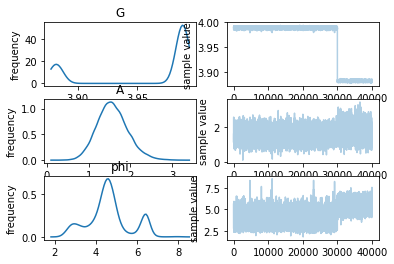

In [99]:
fitsm.plot()
plt.show()

In [100]:
print(fitsm)

Inference for Stan model: anon_model_b9f1cde9e8eb9d266c129191e5bed5bf.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
G      3.96    0.03   0.05   3.88   3.93   3.99   3.99   3.99      2  29.95
A      1.57    0.08   0.37    0.9   1.32   1.55    1.8   2.37     21   1.06
phi    4.62    0.48   1.02   2.69   4.12   4.57   4.99   6.59      5   1.33
lp__ -22.88    0.02   1.45  -26.4 -23.63 -22.69 -21.75 -20.97   5095    1.0

Samples were drawn using NUTS at Fri Nov 30 13:14:41 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


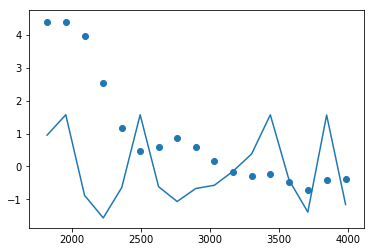

In [101]:
dgstan = fitsm['A'].mean() * np.cos((2*np.pi*(lmodes[0].nu-numax))/fitsm['G'].mean() + fitsm['phi'].mean())

plt.subplots()
plt.plot(lmodes[0].nu, dgstan, label = 'Stan model')
plt.scatter(lmodes[0].nu, deltag, label = 'Data')

Here is a corner plot of the results:

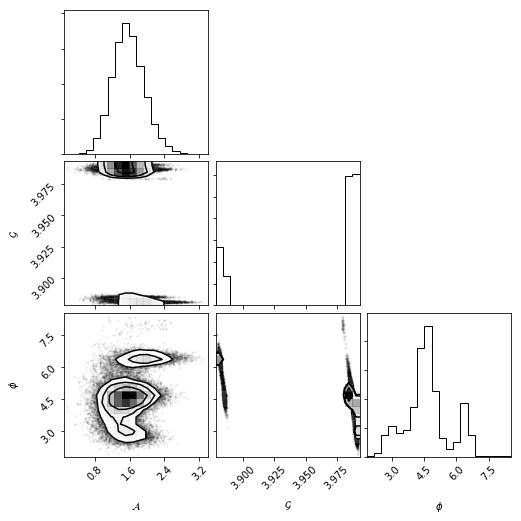

In [102]:
import corner
data = np.vstack([fitsm['A'], fitsm['G'], fitsm['phi']]).T
corner.corner(data, labels=[r'$\mathcal{A}$', r'$\mathcal{G}$', r'$\phi$'])
plt.show()

From Nature volume 215, pages 43–44 (01 July 1967) the helium mass fraction of the sun is between 0.20 and 0.27.